### Import Packages

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# tokenization
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize

# stopword removal
import nltk
import string
import re
from nltk.corpus import stopwords
english_stopwords = stopwords.words("english")

# Vectorization/Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Classifiers
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score

# metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Neural Networks
import tensorflow 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dropout, Input, Dense 
from keras.utils.vis_utils import plot_model
from tensorflow.python.framework.random_seed import set_random_seed


datapath = 'data/'

### Load Data

In [3]:
data = pd.read_csv(datapath + 'disaster_train.csv', sep=',',)

### Tokenize data

we extract the text of the tweets as X vector and the transform them into a `tf-idf` (term-frequency times inverse document-frequency) matrix. 

__TODO__
- At a later stage add location and keyword data to the feature matrix
    - Problem: How do we addjust the weight of those, should they way as much as the occurence of one word or more?
    

In [5]:
# split feature vector and target vector
Y_train = data["target"].values 
X_train = data.values[:, 1:4]

# Get only column with tweet text
x_tweets = data['text']
x_tweets.head()

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [6]:
# Tweet tokenizer for making all alphabetical symbols lowercase, reducing length of words
# if they are e.g. 'goaaaal' and for removing account handles
tknzr = TweetTokenizer(preserve_case = False, strip_handles = True, reduce_len = True)
tweet_tokens = []
for sent in x_tweets:
    #print(tweet_tokenizer.tokenize(sent))
    tweet_tokens.append(tknzr.tokenize(sent))
print(tweet_tokens[:2])

[['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#earthquake', 'may', 'allah', 'forgive', 'us', 'all'], ['forest', 'fire', 'near', 'la', 'ronge', 'sask', '.', 'canada']]


In [9]:
# clean out stopwords, # signs, punctuation and numbers
clean_t2 = [[word if (word.startswith('#') == False) else re.sub(r'#', '', word) for word in tweet] for tweet in tweet_tokens]
clean_t3 = [[word for word in tweet if (word not in string.punctuation) and (word.isalpha() == True) and (word not in english_stopwords)] for tweet in clean_t2]
clean_t3[:2]

[['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us'],
 ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']]

In [11]:
# Transform into correct input form for the Vectorizer
clean_t4 = [' '.join(tweet) for tweet in clean_t3]
x_tweets = np.array(clean_t4)
x_tweets[:2]

array(['deeds reason earthquake may allah forgive us',
       'forest fire near la ronge sask canada'], dtype='<U138')

In [17]:
# split train and test set
X_train, X_test, y_train, y_test = train_test_split(x_tweets, Y_train, test_size=0.15, random_state=42)

# create tf-idf vectorizer
tf_computer = TfidfVectorizer(use_idf=False, ngram_range=(1,1))

# vectorize train and test set
train_features = tf_computer.fit_transform(X_train)
test_features = tf_computer.transform(X_test)

print("vocabulary size:", len(tf_computer.vocabulary_))

vocabulary size: 12427


# First naive try

In [18]:
# select a linear model based on the assumption that specific words (linearly) imply a real disaster or not
# TODO: vary hpyerparameter alpha

clf = RidgeClassifier()
scores = cross_val_score(clf, train_features, y_train, cv=3, scoring="f1")
scores

array([0.7399651 , 0.73634204, 0.73012188])

In [19]:
clf.fit(train_features, y_train)
y_train_pred = clf.predict(train_features)
y_test_pred = clf.predict(test_features)


print('Train F1 score:', np.round(f1_score(y_train, y_train_pred), 3))
print('Test F1 score:', np.round(f1_score(y_test, y_test_pred), 3))

Train F1 score: 0.927
Test F1 score: 0.749


This looks very much like overfitting

# Second (a bit less) naive try
Lets try a neural network.

### Create early stopping mechanism for NN

In [21]:
from keras.callbacks import EarlyStopping

# simple early stopping
es = EarlyStopping(monitor='val_loss', #quantity to be monitored
                   mode='min', #we look for decreasing patterns stop 
                   patience = 3, #number of epochs with no improvement
                   verbose=1)

np.random.seed(123)
set_random_seed(2)

In [22]:
train_features_den = train_features.todense()
feature_vector_length = train_features_den.shape[1]

In [23]:
model = Sequential() #we first define how the "model" looks like
model.add(Dense(input_dim = feature_vector_length, units=100 , activation='relu')) #input layer
model.add(Dense(100, activation='relu'))
model.add(Dense(2, activation='softmax')) #output layer

# Configure the model and start training
model.compile(loss='sparse_categorical_crossentropy', #loss metric
    optimizer='adam',  #optimizer
    metrics=['accuracy']) #displayed metric


history = model.fit(train_features_den, y_train, epochs=10, verbose=2, validation_split=0.2)

2022-01-07 11:43:00.451077: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-07 11:43:00.451113: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-07 11:43:00.451141: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (siprius): /proc/driver/nvidia/version does not exist
2022-01-07 11:43:00.451446: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
162/162 - 2s - loss: 0.5422 - accuracy: 0.7276 - val_loss: 0.4805 - val_accuracy: 0.7722 - 2s/epoch - 12ms/step
Epoch 2/10
162/162 - 2s - loss: 0.2551 - accuracy: 0.9019 - val_loss: 0.5402 - val_accuracy: 0.7815 - 2s/epoch - 9ms/step
Epoch 3/10
162/162 - 1s - loss: 0.1275 - accuracy: 0.9525 - val_loss: 0.6548 - val_accuracy: 0.7807 - 1s/epoch - 9ms/step
Epoch 4/10
162/162 - 1s - loss: 0.0771 - accuracy: 0.9728 - val_loss: 0.7370 - val_accuracy: 0.7730 - 1s/epoch - 9ms/step
Epoch 5/10
162/162 - 1s - loss: 0.0572 - accuracy: 0.9772 - val_loss: 0.8320 - val_accuracy: 0.7668 - 1s/epoch - 9ms/step
Epoch 6/10
162/162 - 1s - loss: 0.0457 - accuracy: 0.9801 - val_loss: 0.9036 - val_accuracy: 0.7676 - 1s/epoch - 9ms/step
Epoch 7/10
162/162 - 1s - loss: 0.0390 - accuracy: 0.9832 - val_loss: 0.9872 - val_accuracy: 0.7683 - 1s/epoch - 9ms/step
Epoch 8/10
162/162 - 1s - loss: 0.0361 - accuracy: 0.9832 - val_loss: 1.0204 - val_accuracy: 0.7583 - 1s/epoch - 9ms/step
Epoch 9/10
162/162 - 1s

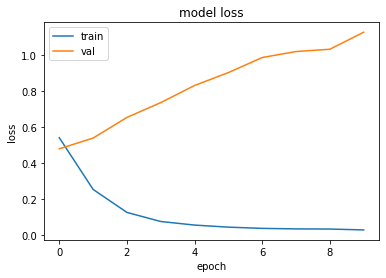

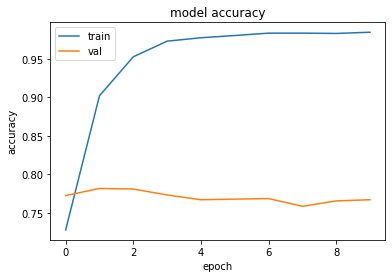

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.ylim(0.8, 1)
plt.show()


In [25]:
model.fit(train_features_den, y_train)
y_train_pred = clf.predict(train_features_den)
y_test_pred = clf.predict(test_features.todense())


print('Train F1 score:', np.round(f1_score(y_train, y_train_pred), 3))
print('Test F1 score:', np.round(f1_score(y_test, y_test_pred), 3))

203/203 [==============================] - 2s 9ms/step - loss: 0.1929 - accuracy: 0.9334
Train F1 score: 0.927
Test F1 score: 0.749


/home/jan/ds/ml/nlp-project/nlp-venv/lib/python3.8/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/jan/ds/ml/nlp-project/nlp-venv/lib/python3.8/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [27]:
print('Train F1 score:', np.round(accuracy_score(y_train, y_train_pred), 3))
print('Test F1 score:', np.round(accuracy_score(y_test, y_test_pred), 3))

Train F1 score: 0.939
Test F1 score: 0.795


The former model does not improve after the first few epochs, afterwards train and validation acc both only slightly fluctuate. The Train accuracy raises quickly over the first epochs up to 99.7% (epoch 9). The validation accuracy on the other hand slightly falls. This indicates that our model not really learns a lot. It becomes able to predict the training set very well, but the accuracy on the validattion set stays at the same level (overfitting).

### Model Variation

In the following section we will try out different architectures for our model. To do so we will vary the activation function and the depth of the model.

In [28]:
#  the function can be used in a loop to define several models

def MLP_definer(n_layers, n_features, n_classes, activation_f):
    
    model = Sequential()
    model.add(Dense(input_dim = n_features, units=500, activation=activation_f))
    for i in range(1, n_layers):
        model.add(Dense(units=500-10*i^2, activation=activation_f))
        
    model.add(Dense(units=n_classes, activation='softmax'))
    return model

In [ ]:
out = {}
for fun in ('relu', 'sigmoid'):
    print(f'Activation function: {fun}')
    for i in range(2,7):    
        model = MLP_definer(i, n_features=feature_vector_length, n_classes=2, activation_f=fun)
        model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer='adam',
            metrics='accuracy'
        )
        history = model.fit(train_features_den, y_train, batch_size=16, epochs=500, validation_split=0.25, verbose=0, callbacks=[es])
        out[i] = [history.history['accuracy'][-1],  history.history['val_accuracy'][-1]]
        print(f'Number of layers: {i} \nTrain Acc: {history.history["accuracy"][-1]} \nTest Acc:  {history.history["val_accuracy"][-1]}')

Activation function: relu
Epoch 00004: early stopping
Number of layers: 2 
Train Acc: 0.9793941974639893 
Test Acc:  0.7700865268707275
Epoch 00004: early stopping
Number of layers: 3 
Train Acc: 0.9779517650604248 
Test Acc:  0.7688504457473755
Epoch 00004: early stopping
Number of layers: 4 
Train Acc: 0.9775396585464478 
Test Acc:  0.7719406485557556
Epoch 00004: early stopping
Number of layers: 5 
Train Acc: 0.9765093922615051 
Test Acc:  0.7663782238960266
Epoch 00004: early stopping
Number of layers: 6 
Train Acc: 0.9713579416275024 
Test Acc:  0.7639060616493225
Activation function: sigmoid
Epoch 00005: early stopping
Number of layers: 2 
Train Acc: 0.9509581923484802 
Test Acc:  0.7805933356285095
Epoch 00005: early stopping
Number of layers: 3 
Train Acc: 0.943952202796936 
Test Acc:  0.7775030732154846
